In [1]:
import pandas as pd
import numpy as np
import scipy
from plotnine import *

import sklearn
from sklearn.tree import DecisionTreeClassifier, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

import math
from pathlib import Path
from functools import partial, reduce
from typing import Union
import os
import shutil
from collections import Counter, namedtuple, defaultdict
import re

In [2]:
col_names = '''2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)
'''

col_names = col_names.splitlines()
pattern_name = re.compile('[a-zA-Z ]+')
col_names = ['_'.join(pattern_name.search(c).group(0)[1:].lower().split(' ')) for c in col_names]

In [3]:
path_data = Path('./data')
df_cancer_raw = pd.read_csv(path_data/'hw2_question1.csv', names=col_names)
print(df_cancer_raw.shape)
df_cancer_raw.head()

(683, 10)


,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [4]:
def group_split(df, col, pct=0.33) -> namedtuple:
    split_col = df[col]
    split_unique = np.unique(split_col)
    all_indices = np.arange(df.shape[0])
    
    indices = np.array([], dtype=np.int16)
    for i in split_unique:
        group_indices = all_indices[split_col == i]
        selected_indices = np.random.choice(group_indices, round(group_indices.size*pct), replace=False)
        indices = np.hstack([indices, selected_indices])
        
    df_test = df.iloc[indices]
    df_train = df.loc[~np.isin(np.arange(df.shape[0]), indices)] #~np.isin(np.arange(df.shape[0]), indices)

    split_dfs = namedtuple('split_dfs', 'train test test_indices')
    return split_dfs(df_train, df_test, indices)

def x_and_resp(df, resp_col):
    X = df.drop(resp_col, axis=1)
    y = df[resp_col]
    return X, y

In [5]:
df_tr, df_ts, _ = group_split(df_cancer_raw, 'class')
tr_X, tr_y = x_and_resp(df_tr, 'class')
ts_X, ts_y = x_and_resp(df_ts, 'class')
tr_X.shape

(457, 9)

In [28]:
class BinaryTree():
    
    def __init__(self, indices, feature, value, entropy):
        self.indices, self.feature = indices, feature
        self.value, self.entropy = value, entropy
        


class TreeClassifier():
    
    def __init__(self, split_cond='entropy', split_as_numeric=True):
        self.split_cond, self.split_as_numeric = split_cond, split_as_numeric
        
    def fit(self, X, y):
        self.X, self.y = X.reset_index(drop = True), y.reset_index(drop = True)
        self.splits = self.create_splits()
        
    def entropy(self, x: np.ndarray):
        counts = np.unique(x, return_counts=True)[1]
        probs = counts/counts.sum()
        if self.split_cond == 'entropy':
            return -np.dot(probs, np.log2(probs))
        else:
            return 1-((probs**2).sum())
        
    def create_splits(self, indices=None):
        indices = np.arange(self.X.shape[0]) if indices is None else indices
        
        split_info = namedtuple('split_info', 'feature splitval cat nodes')
        
        cats, counts = np.unique(self.y.loc[indices].values, return_counts=True)
        cat = np.asscalar(cats[counts == counts.max()][0])
        
        if self.entropy(self.y.loc[indices]) == 0.0:
            return split_info(None, None, cat, [None, None])
        else:
            feature, split_value, best_entropy = self.get_best_split(indices)
            left_indices = indices[self.X.loc[indices][feature] <= split_value]
            right_indices = indices[self.X.loc[indices][feature] > split_value]
            
            l = self.create_splits(left_indices)
            r = self.create_splits(right_indices)
            
            return split_info(feature, split_value, cat, [l, r])
        
    def get_best_split(self, current_indices):
        entropies = self.calc_entropies_cols(current_indices)
        best_entropy = math.inf
        for c in sorted(self.X.columns, reverse=True):
            splitpoint_entropies = entropies[c]
            for s, e in splitpoint_entropies.items():
                if e < best_entropy:
                    best_entropy, feature, splitpoint = e, c, s
#         print(feature, '<=', splitpoint) #, ':', best_entropy
        return feature, splitpoint, best_entropy

    def calc_entropies_cols(self, current_indices):
        return {c:self.calc_entropies_col(c, current_indices) for c in self.X.columns}

    def calc_entropies_col(self, split_colname, current_indices):
        X = self.X.loc[current_indices]
        split_col = X[split_colname]
        levels, probs = self.get_split_points(split_col)
        y = self.y.loc[current_indices]
        
        entropies = defaultdict(int)
        for l, p in zip(levels, probs):
            selected_level = split_col <= l if self.split_as_numeric else split_col == l
            entropies[l] = p * self.entropy(y[selected_level]) + (1-p) * self.entropy(y[~selected_level]) 
        return entropies
     
    def get_split_points(self, split_col):
        levels, counts = np.unique(split_col, return_counts=True)
        probs = counts/counts.sum()
        
        if self.split_as_numeric:
            new_levels = []
            new_probs = []
            for i in range(levels.size-1):
                new_levels.append((levels[i] + levels[i+1])/2)
                new_probs.append(probs[i] if len(new_probs) == 0 else new_probs[i-1]+probs[i])
            return np.array(new_levels), np.array(new_probs)
        else:
            return levels, probs

    def evaluate(self, ts_X, ts_y):
        preds = self.predict(ts_X)
        return (ts_y == preds).mean()            
               
    def predict(self, ts_X):
        return ts_X.apply(self.predict_rec, axis=1)

    def predict_rec(self, rec):
        split = self.splits
        while getattr(split, 'nodes') != [None, None]:
            f, v, c, ns = split
            split = ns[0] if rec[f]<=v else ns[1]
        return getattr(split, 'cat')
    
    

my_tree = TreeClassifier(split_cond='gini', split_as_numeric=True)
my_tree.fit(tr_X, tr_y)
my_tree.evaluate(ts_X, ts_y)

0.9424778761061947

0.9424778761061947


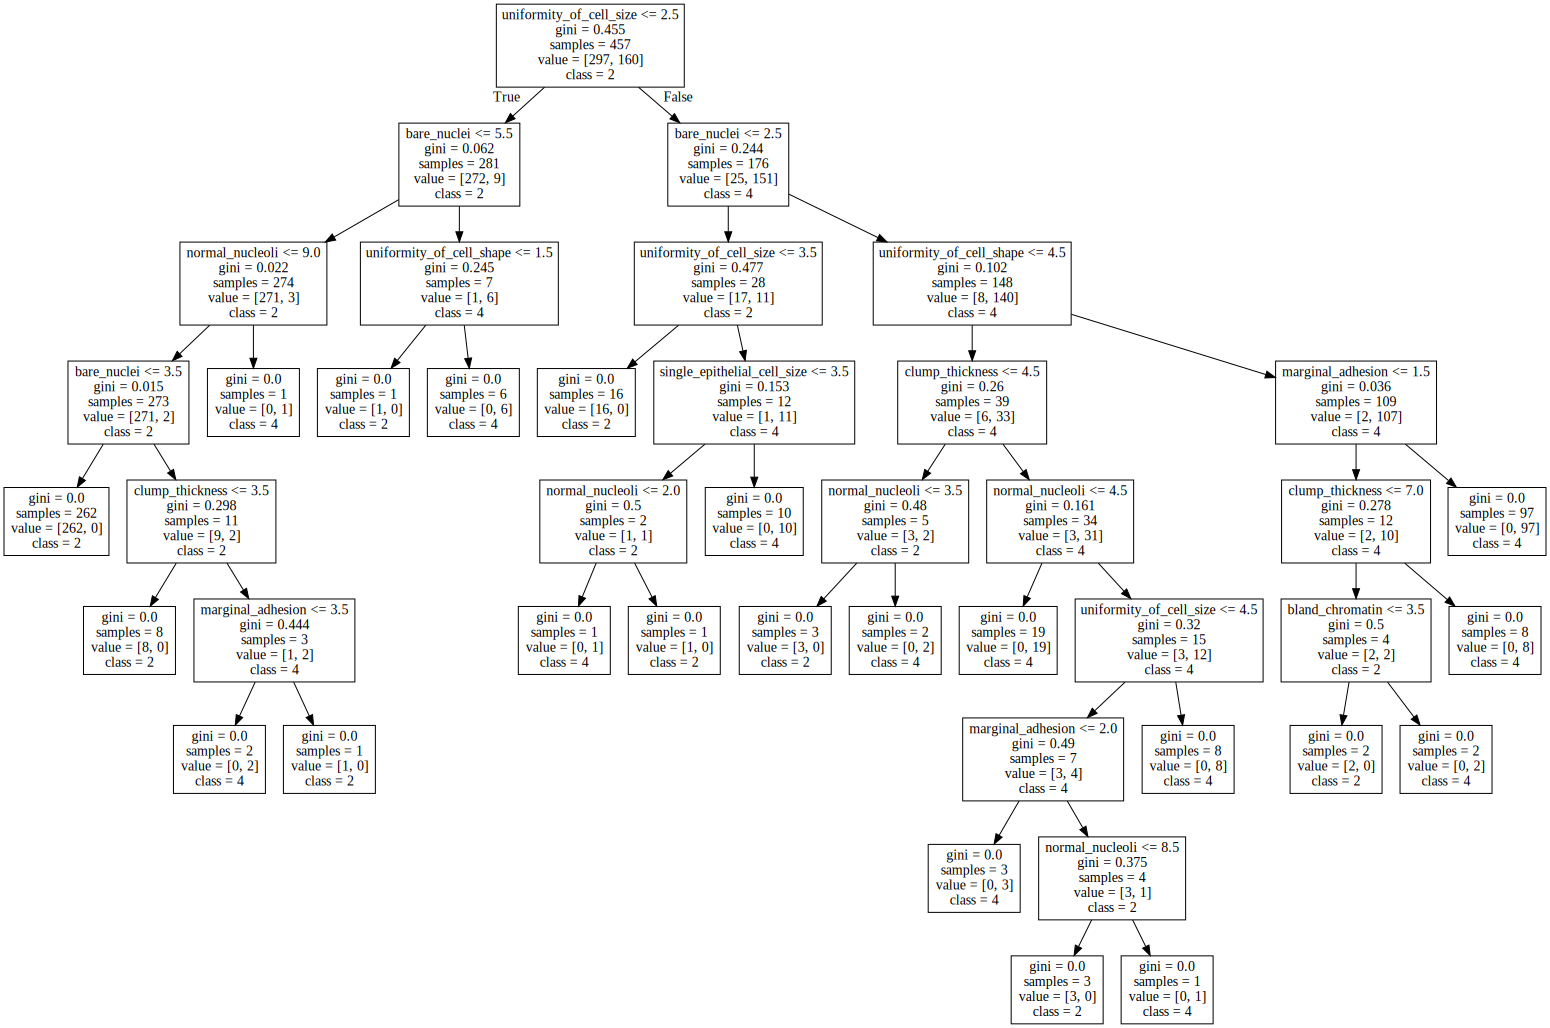

In [27]:
tr_X_cp = tr_X.copy()
sklearn_tree = DecisionTreeClassifier(criterion='gini')
sklearn_tree.fit(tr_X_cp, tr_y)
from graphviz import Source
graph = Source(sklearn.tree.export_graphviz(sklearn_tree, class_names=['2', '4'],
                                            out_file=None, feature_names=tr_X_cp.columns))
print(sklearn_tree.score(ts_X, ts_y))
graph

In [ ]:

# tr_X_cp = pd.get_dummies(tr_X_cp, columns=tr_X_cp.columns)
# ohe = OneHotEncoder(categories='auto', sparse=False) #categories=[str(i) for i in range(11)]
# ohe.fit_transform(tr_X_cp)
# tr_X_cp.head()